# Project: Maven MegaMart 

### Business Case

**Maven MegaMart** is a multinational corporation that operates a chain of retail and grocery stores. They recently received a sample of data from a new **retailer** they're looking to **acquire**.

### Project Objectives

To **identify** and deliver **key insights** about the retailers **sales history**.

I will do this by analyzing transaction history by **product**, **household** and **store** to get a better understanding of the retailer's **main strengths**.

### Import Libraries

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns



* First, read in the transactions data.

* Read in the only columns `household_key`, `BASKET_ID`, `DAY`, `PRODUCT_ID`, `QUANTITY`, and `SALES_VALUE`.

* Convert `DAY`, `QUANTITY`, and `PRODUCT_ID` to the smallest appropriate integer types.


### Read in the transactions data

In [110]:
transactions = pd.read_csv('../project_data/project_transactions.csv',
                           usecols = ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 
                                      'QUANTITY', 'SALES_VALUE'],
                           dtype = {"DAY": "Int16", "QUANTITY": "Int32", "PRODUCT_ID": "Int32"})

transactions.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE
0,1364,26984896261,1,842930,1,2.19
1,1364,26984896261,1,897044,1,2.99
2,1364,26984896261,1,920955,1,3.09
3,1364,26984896261,1,937406,1,2.50
4,1364,26984896261,1,981760,1,0.60


In [111]:
transactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int64  
 1   BASKET_ID      int64  
 2   DAY            Int16  
 3   PRODUCT_ID     Int32  
 4   QUANTITY       Int32  
 5   SALES_VALUE    float64
dtypes: Int16(1), Int32(2), float64(1), int64(2)
memory usage: 75.7 MB


In [112]:
# Use the following snippet to create a Date Column.
transactions = (
    transactions
    .assign(date = (pd.to_datetime("2016", format='%Y') 
                    + pd.to_timedelta(transactions["DAY"].sub(1).astype(str) + " days"))
           )
    .drop(["DAY"], axis=1)
)

In [113]:
transactions.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


## 1. TIME BASED ANALYSIS

* Plot the sum of sales by month. Are sales growing over time?
* Next, plot the same series after filtering down to dates April 2016 and October 2017.
* Then, plot the sum of monthly sales in 2016 vs the monthly sales 2017.
* Finally, plot total sales by day of week.

#### Step 1: Plot the sum of sales by month

In [114]:
monthly_sales = transactions.set_index('date').loc[:, 'SALES_VALUE'].resample('M').sum().to_frame()

monthly_sales

,SALES_VALUE
date,
2016-01-31,46557.97
2016-02-29,97315.16
2016-03-31,185521.82
2016-04-30,267801.38
2016-05-31,298319.14
2016-06-30,288952.45
2016-07-31,296488.02
2016-08-31,303951.35
2016-09-30,302040.56


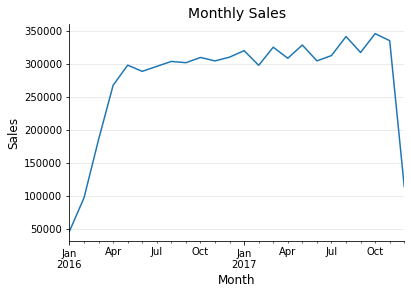

In [115]:
transactions.set_index('date').loc[:, 'SALES_VALUE'].resample('M').sum().plot()

plt.title('Monthly Sales', size=14)
plt.xlabel('Month', size=12)
plt.ylabel('Sales', size=12)
plt.grid(alpha=0.3, axis='y')
sns.despine();

#### Step 2: Plot the sales by month for the dates between April 2016 and October 2017

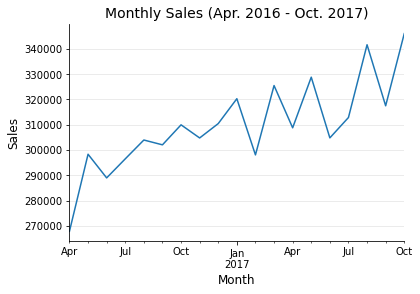

In [116]:
transactions.set_index('date').loc['2016-04':'2017-10', 'SALES_VALUE'].resample('M').sum().plot()

plt.title('Monthly Sales (Apr. 2016 - Oct. 2017)', size=14)
plt.xlabel('Month', size=12)
plt.ylabel('Sales', size=12)
plt.grid(alpha=0.3, axis='y')
sns.despine();

#### Step 3: Plot the sum of monthly sales for 2016 and 2017

In [117]:
(transactions
 .set_index("date")
 .loc[:, ["SALES_VALUE"]]
 .resample("M")
 .sum()
 .assign(year_prior = lambda x: x["SALES_VALUE"].shift(12)) # create new column with 2016 monthly sales
 .loc['2017'])

,SALES_VALUE,year_prior
date,,
2017-01-31,320301.20,46557.97
2017-02-28,298058.26,97315.16
2017-03-31,325511.23,185521.82
2017-04-30,308786.99,267801.38
2017-05-31,328829.68,298319.14
2017-06-30,304792.96,288952.45
2017-07-31,312853.52,296488.02
2017-08-31,341670.16,303951.35
2017-09-30,317498.59,302040.56


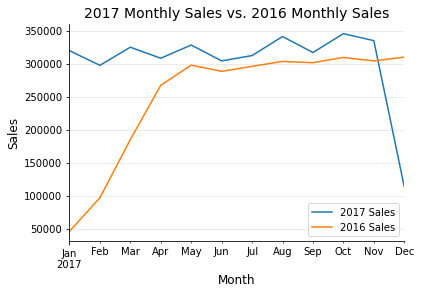

In [118]:
(transactions
 .set_index("date")
 .loc[:, ["SALES_VALUE"]]
 .resample("M")
 .sum()
 .assign(year_prior = lambda x: x["SALES_VALUE"].shift(12))
 .loc['2017']).plot()

plt.title('2017 Monthly Sales vs. 2016 Monthly Sales', size=14)
plt.xlabel('Month', size=12)
plt.ylabel('Sales', size=12)
plt.legend(['2017 Sales', '2016 Sales'], loc='best')
plt.grid(alpha=0.3, axis='y')
sns.despine();

#### Step 4: Plot sales by day of week

In [119]:
weekly_sales = transactions.groupby(transactions['date'].dt.dayofweek)['SALES_VALUE'].sum()

weekly_sales

date
0    1136462.30
1    1172457.99
2     920957.10
3     839884.07
4     832957.98
5     833944.67
6     929579.39
Name: SALES_VALUE, dtype: float64

In [120]:
transactions['day_of_week'] = transactions['date'].dt.day_name()

In [121]:
transactions.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date,day_of_week
0,1364,26984896261,842930,1,2.19,2016-01-01,Friday
1,1364,26984896261,897044,1,2.99,2016-01-01,Friday
2,1364,26984896261,920955,1,3.09,2016-01-01,Friday
3,1364,26984896261,937406,1,2.50,2016-01-01,Friday
4,1364,26984896261,981760,1,0.60,2016-01-01,Friday


In [122]:
categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [123]:
transactions['day_of_week'] = pd.Categorical(transactions['day_of_week'], categories=categories, ordered=True)

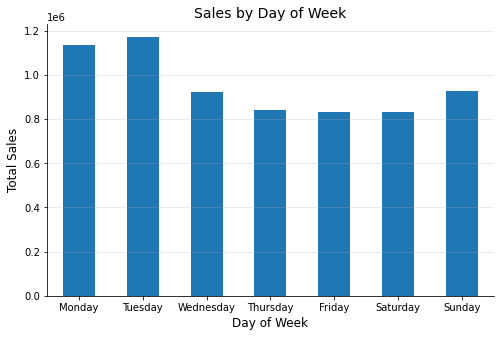

In [144]:
plt.figure(figsize=(8, 5))

transactions.groupby('day_of_week')['SALES_VALUE'].sum().plot(kind='bar')

plt.title('Sales by Day of Week', size=14)
plt.xlabel('Day of Week', size=12)
plt.xticks(rotation=0)
plt.ylabel('Total Sales', size=12)
plt.grid(axis='y', alpha=0.3)
sns.despine();

### Observations

* Sales increased rapidly from January to May of 2016 and steadily increased for the rest of the year.
* Sales for each month were greater in 2017 then they were for the same month in 2016.
* The best months for sales tends to be from October to December.
* Tuesday has the most sales which is surprising since it is a weekday. 
* Thursday, Friday and Saturday have roughly the same amount of sales.

# DEMOGRAPHICS

* Read in the `hh_demographic.csv` file, but only the columns `AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`. Convert the appropriate columns to the category dtype.


* Then group the transactions table by household_id, and calculate the sum of SALES VALUE by household.


* Once you've done that, join the demographics DataFrame to the aggregated transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc (in separate charts).


* Then, create a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`. Which of our demographics have the highest average sales?


#### Step 1: Read in the demographics file

In [125]:
path = '../project_data/hh_demographic.csv'

dem_cols = ['AGE_DESC', 'INCOME_DESC', 'household_key', 'HH_COMP_DESC']

dem_dtypes = {"AGE_DESC": "category", "INCOME_DESC": "category", "HH_COMP_DESC":"category"}

In [126]:
demographics = pd.read_csv(path, usecols=dem_cols, dtype=dem_dtypes)

demographics.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [127]:
# Check if column datatypes have been converted correctly
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   AGE_DESC       801 non-null    category
 1   INCOME_DESC    801 non-null    category
 2   HH_COMP_DESC   801 non-null    category
 3   household_key  801 non-null    int64   
dtypes: category(3), int64(1)
memory usage: 9.5 KB


#### Step 2: Calculate the sum of sales by household

In [128]:
household_sales = transactions.groupby('household_key').agg({'SALES_VALUE': 'sum'})

household_sales.head(10)

,SALES_VALUE
household_key,
1,4330.16
2,1954.34
3,2653.21
4,1200.11
5,779.06
6,5996.16
7,3400.05
8,5534.97
9,797.42


#### Step 3: Join demographics dataframe with household sales

In [129]:
demographic_plus_household = demographics.merge(household_sales, on='household_key', how='inner')

demographic_plus_household.head()

,AGE_DESC,INCOME_DESC,HH_COMP_DESC,household_key,SALES_VALUE
0,65+,35-49K,2 Adults No Kids,1,4330.16
1,45-54,50-74K,2 Adults No Kids,7,3400.05
2,25-34,25-34K,2 Adults Kids,8,5534.97
3,25-34,75-99K,2 Adults Kids,13,13190.92
4,45-54,50-74K,Single Female,16,1512.02


#### Step 4: Plot Sales by Age group

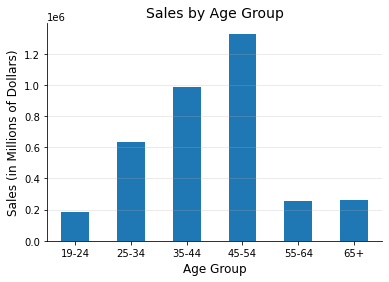

In [143]:
demographic_plus_household.groupby('AGE_DESC')['SALES_VALUE'].sum().plot(kind='bar')

plt.title('Sales by Age Group', size=14)
plt.ylabel('Sales (in Millions of Dollars)', size=12)
plt.xlabel('Age Group', size=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
sns.despine();

#### Step 5: Plot Sales by Income Range

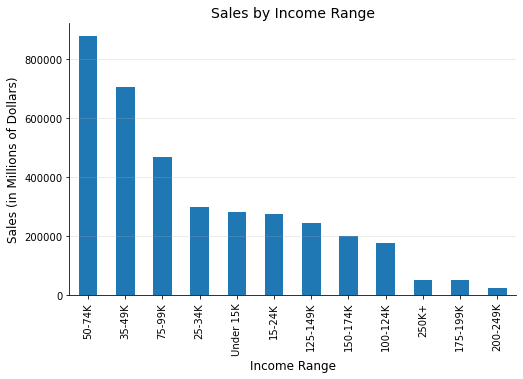

In [154]:
plt.figure(figsize=(8,5))

(demographic_plus_household.groupby('INCOME_DESC')['SALES_VALUE']
                           .sum()
                           .sort_values(ascending=False)
                           .plot(kind='bar'))

plt.title('Sales by Income Range', size=14)
plt.ylabel('Sales (in Millions of Dollars)', size=12)
plt.xlabel('Income Range', size=12)
plt.grid(axis='y', alpha=0.3)
sns.despine();

#### Step 6: Create a pivot table calculating the average sales by age group and household composition

In [171]:
# How many households in each age group and household composition combination
demographic_plus_household.groupby(['AGE_DESC', 'HH_COMP_DESC']).size().unstack()

HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown
AGE_DESC,,,,,,
19-24,3,8,15,9,2,2
25-34,16,37,24,17,21,2
35-44,9,53,45,29,15,11
45-54,12,49,74,37,24,44
55-64,1,6,19,13,8,3
65+,1,3,28,17,10,1


In [156]:
(demographic_plus_household.pivot_table(index='AGE_DESC', columns='HH_COMP_DESC', 
                                        values='SALES_VALUE', aggfunc='mean',
                                        margins=True)
                           .style.background_gradient(cmap="RdYlGn", axis=1)
)

HH_COMP_DESC,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
AGE_DESC,,,,,,,
19-24,7268.796667,5428.945000,4020.800000,4576.095556,3216.835000,4911.275000,4692.077692
25-34,5512.196875,5753.973514,5638.515833,4807.440588,4909.522381,7356.270000,5435.517521
35-44,6297.737778,6691.772264,6260.412444,6015.192069,4844.192000,4227.691818,6090.556728
45-54,6632.569167,6610.484490,5839.527027,4549.365405,4636.637083,4843.995682,5534.879958
55-64,3064.870000,4695.655000,5752.413684,4816.148462,3922.546250,7973.750000,5168.924200
65+,4040.810000,5536.866667,4614.108571,4059.699412,3871.556000,2879.290000,4340.936500
All,6032.802143,6280.069103,5599.857756,4895.928361,4544.646750,4936.127778,5468.398743


### Observations

* The age group which generated the most sales is between **45 - 54** years old.
* The income group which generated the most sales earn an income between **\\$50,000 - \\$74,000** per year.
* The **55-64** age group whose household composition is **unknown** generate the highest average sales.

# PRODUCT DEMOGRAPHICS

* Read in the product csv file.

* Only read in product_id and department from product (consider converting columns).

* Join the product DataFrame to transactions and demographics tables, performing an inner join when joining both tables.

* Finally, pivot the fully joined dataframe by AGE_DESC and DEPARTMENT, calculating the sum of sales. Which category does our youngest demographic perform well in?



#### Step 1: Read in products file

In [161]:
path = '../project_data/product.csv'

product_cols = ['PRODUCT_ID', 'DEPARTMENT']

product_dtypes = {'PRODUCT_ID': 'Int32', 'DEPARTMENT': 'category'}

In [162]:
products = pd.read_csv(path, usecols=product_cols, dtype=product_dtypes)

products.head()

,PRODUCT_ID,DEPARTMENT
0,25671,GROCERY
1,26081,MISC. TRANS.
2,26093,PASTRY
3,26190,GROCERY
4,26355,GROCERY


In [163]:
# Check if column datatypes have been converted properly
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   PRODUCT_ID  92353 non-null  Int32   
 1   DEPARTMENT  92353 non-null  category
dtypes: Int32(1), category(1)
memory usage: 542.6 KB


#### Step 2: Merge transactions, demographics and products dataframes

In [164]:
# Merge dataframes
combined_df = (
 transactions.merge(demographics, how='inner', left_on='household_key', right_on='household_key')
             .merge(products, how='inner', left_on='PRODUCT_ID', right_on='PRODUCT_ID')
              )

combined_df.head()

,household_key,BASKET_ID,PRODUCT_ID,QUANTITY,SALES_VALUE,date,day_of_week,AGE_DESC,INCOME_DESC,HH_COMP_DESC,DEPARTMENT
0,1364,26984896261,842930,1,2.19,2016-01-01,Friday,65+,100-124K,Single Female,GROCERY
1,304,27950201718,842930,1,1.67,2016-03-21,Monday,25-34,50-74K,2 Adults No Kids,GROCERY
2,575,34186568032,842930,1,1.67,2017-04-29,Saturday,35-44,50-74K,Single Female,GROCERY
3,77,28023861855,842930,3,5.00,2016-03-27,Sunday,35-44,100-124K,2 Adults Kids,GROCERY
4,454,42136182098,842930,1,1.67,2017-11-29,Wednesday,55-64,35-49K,Single Male,GROCERY


#### Step 3: Create a Pivot Table calculating sum of sales by category and age group

In [170]:
(combined_df.pivot_table(index='DEPARTMENT', columns='AGE_DESC',
                        values='SALES_VALUE', aggfunc='sum')
           .style.background_gradient(cmap="RdYlGn", axis=1))

AGE_DESC,19-24,25-34,35-44,45-54,55-64,65+
DEPARTMENT,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.640000,21.250000,72.580000,55.920000,0.000000,16.370000
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300000,134.160000,348.530000,418.240000,80.860000,149.240000
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630000,2273.030000,4362.020000,5187.570000,986.260000,600.900000
COUP/STR & MFG,7.490000,48.420000,121.200000,154.550000,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300000,18181.940000,34577.290000,44334.220000,9850.540000,10462.330000


### Observations

* The youngest age group in the dataset is between **19-24 years** old.
* This age group performs best in the **Spirits** category. This could be because people in this age group may be in college/university where a lot of drinking takes place.

# EXPORT

Finally, export your pivot table to an excel file. Make sure to provide a sheet name.

In [192]:
(combined_df.pivot_table(index="DEPARTMENT",
                            columns="AGE_DESC",
                            values="SALES_VALUE",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1)
 .to_excel("demographic_category_sales.xlsx", sheet_name="sales_pivot")
)